# Medical Transcriptions Categorization

## Imports

In [31]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords #corpus of stop words
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Import dataset

In [32]:
df = pd.read_csv('mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


### Data cleanup

In [33]:
#drop unneeded columns
df.drop(['Unnamed: 0','description','sample_name','keywords'], axis = 1, inplace = True)
df.head()


,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [34]:
df['medical_specialty'].value_counts()

 Surgery                          1103
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        372
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  230
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Obstetrics / Gynecology           160
 Urology                           158
 Discharge Summary                 108
 ENT - Otolaryngology               98
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    62
 Psychiatry / Psychology            53
 Office Notes                       51
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

In [35]:
#check for null transcripts and drop
df.isnull().sum()

medical_specialty     0
transcription        33
dtype: int64

In [36]:
df.dropna(inplace = True)

In [37]:
df.reset_index(drop = True, inplace = True)
df.describe()

,medical_specialty,transcription
count,4966,4966
unique,40,2357
top,Surgery,"PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO..."
freq,1088,5


## Exploratory Data Analysis

### Number of characters in each transcription

<AxesSubplot:>

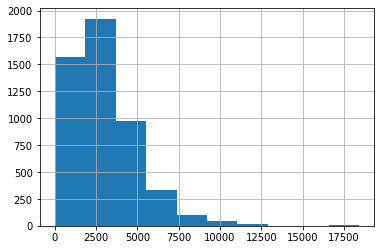

In [38]:
df['transcription'].str.len().hist()

### Number of words in each transcription

<AxesSubplot:>

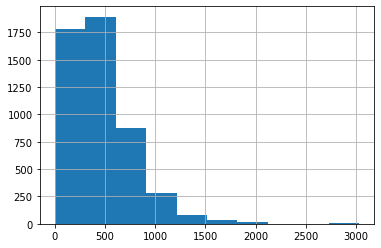

In [39]:
df['transcription'].str.split().map(lambda x: len(x)).hist()

### Average word length for in each transcription

<AxesSubplot:>

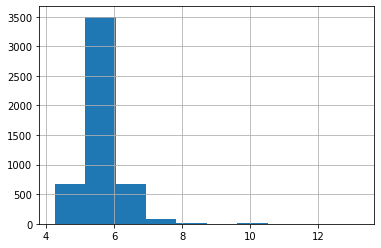

In [40]:
df['transcription'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

### Stopwords in transcriptions

In [41]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\henry\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


<BarContainer object of 10 artists>

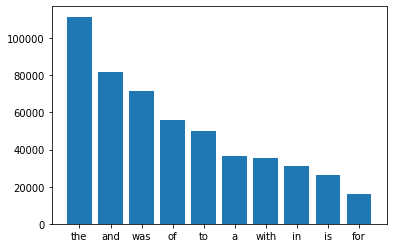

In [42]:
corpus=[]
new= df['transcription'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

### Frequently occuring words 
#### Not including stopwords

<AxesSubplot:>

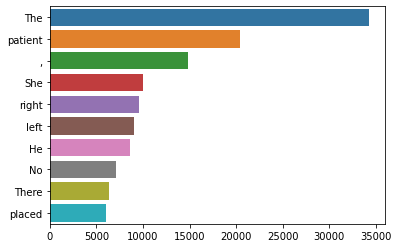

In [43]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
#TODO: remove stopwords

### N-grams

In [44]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)


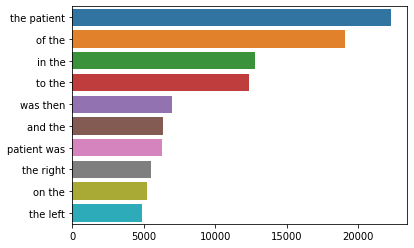

In [45]:
plot_top_ngrams_barchart(df['transcription'],2)

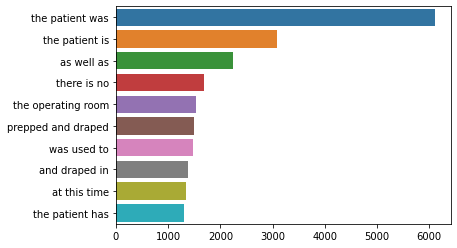

In [46]:
plot_top_ngrams_barchart(df['transcription'],3)

In [47]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for trans in df['transcription']:
        words=[w for w in word_tokenize(trans) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus=preprocess_news(df)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\henry/nltk_data'
    - 'C:\\Users\\henry\\AppData\\Local\\Programs\\Python\\Python39\\nltk_data'
    - 'C:\\Users\\henry\\AppData\\Local\\Programs\\Python\\Python39\\share\\nltk_data'
    - 'C:\\Users\\henry\\AppData\\Local\\Programs\\Python\\Python39\\lib\\nltk_data'
    - 'C:\\Users\\henry\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)